<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/all_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!date

Thu Jul  1 04:47:55 UTC 2021


In [3]:
!rm -rf BMGP_2020
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 756, done.
remote: Counting objects: 100% (460/460), done.
remote: Compressing objects: 100% (389/389), done.
remote: Total 756 (delta 195), reused 228 (delta 68), pack-reused 296
Receiving objects: 100% (756/756), 469.99 MiB | 24.04 MiB/s, done.
Resolving deltas: 100% (286/286), done.
Checking out files: 100% (152/152), done.


In [4]:
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
  !pip install --quiet \
  kb-python==0.26.0 \
  anndata==0.7.6
  !pip install --no-deps -i https://test.pypi.org/simple/ diffmx==0.0.5


     |████████████████████████████████| 59.1MB 54kB/s 
     |████████████████████████████████| 133kB 31.9MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 20.6MB 96kB/s 
     |████████████████████████████████| 11.3MB 188kB/s 
     |████████████████████████████████| 112kB 56.0MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 1.2MB 33.1MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
Looking in indexes: https://test.pypi.org/simple/


In [5]:
!gunzip BMGP_2020/data/*/*.h5ad.gz

In [6]:
import anndata
from glob import glob
from scipy.io import mmread, mmwrite
from kb_python.utils import import_matrix_as_anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from diffmx import plot, compare
from diffmx.utils import nd, yex

fsize = 18

plt.rcParams.update({'font.size': fsize})

%config InlineBackend.figure_format = 'retina'

In [7]:
files = glob("BMGP_2020/data/*/*.h5ad")

In [8]:
names = []
data = []
for f in files:
  name = name = f.split("/")[-1].split(".")[0]
  d = anndata.read_h5ad(f)
  if name != 'tapseq':
    names.append(name)
    data.append(d)
  else:
    tapseq = d

In [9]:
data

[AnnData object with n_obs × n_vars = 3795 × 8
     var: 'feature_name'
     layers: '0', '1', AnnData object with n_obs × n_vars = 5266 × 32
     var: 'feature_name'
     layers: '0', '1', AnnData object with n_obs × n_vars = 10807 × 8
     var: 'feature_name'
     layers: '0', '1', AnnData object with n_obs × n_vars = 2799 × 90
     var: 'feature_name'
     layers: '0', '1', AnnData object with n_obs × n_vars = 11568 × 9
     var: 'feature_name'
     layers: '0', '1']

In [10]:
delta = [(i.layers['0'].mean() - i.layers['1'].mean()) for i in data]
n_cells = [i.shape[0] for i in data]

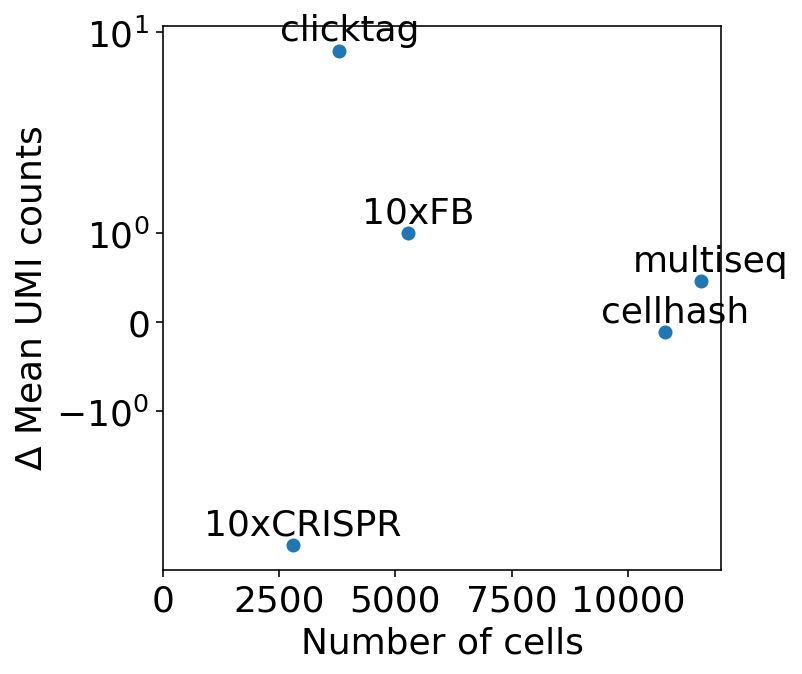

In [11]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(n_cells, delta)

for (x,y,t) in zip(n_cells, delta, names):
  
  ax.annotate(t, (x,y), ha="center", xycoords='data',
            xytext=(5, 5), textcoords='offset points',)

ax.set(**{
    "yscale": "symlog", 
    "xlabel": "Number of cells",
    "ylabel": "$\Delta$ Mean UMI counts",
    "xlim": 0
    })

fig.show()

In [12]:
 corr = [compare.features_correlated(i.layers['0'], i.layers['1'])[1] for i in data]
 n_feat = [i.shape[1] for i in data]

In [13]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


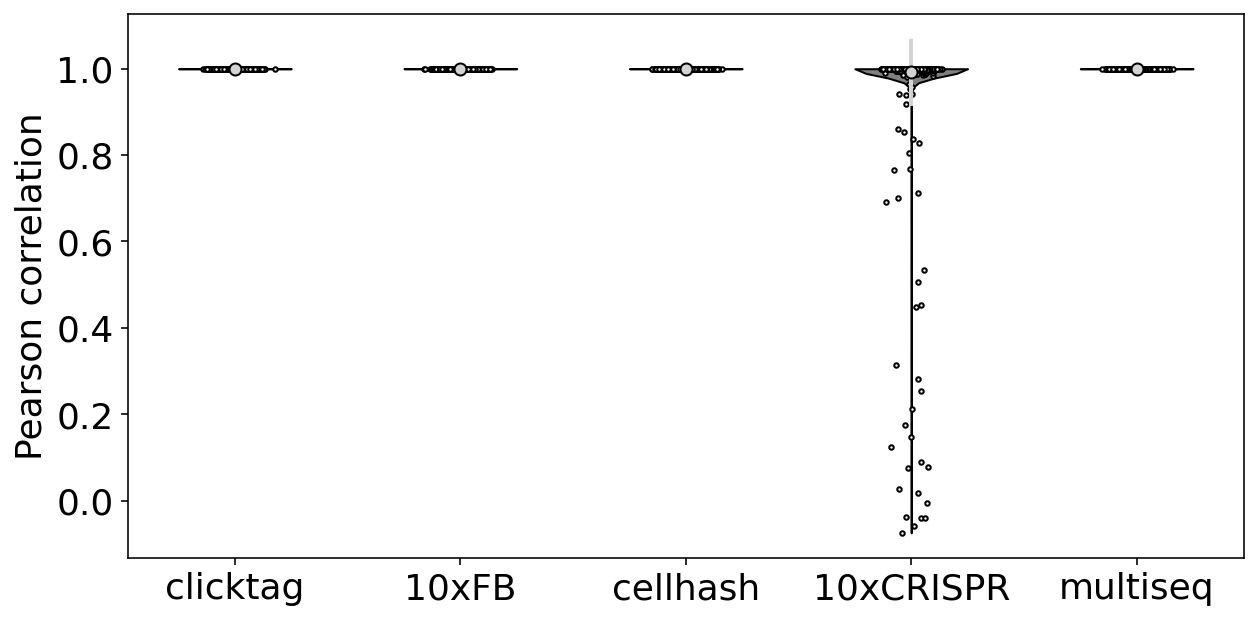

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

violinplot(corr, ax, xticklabels=names)
ax.set(**{
    "ylabel": "Pearson correlation",
})
fig.show()

In [18]:
[(name, i.mean()) for name, i in zip(names, corr)]

[('clicktag', 0.9999834257913326),
 ('10xFB', 0.9999808521438808),
 ('cellhash', 0.999998764078696),
 ('10xCRISPR', 0.9921092975476486),
 ('multiseq', 0.9999988752780213)]